# Load functions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import gc
import random
import json


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
def eda(pdf, list_col):
    import matplotlib.pyplot as plt
    for c in list_col:
        pdf[c].plot.hist(bins =120, alpha = 0.5)
        plt.title(f"Distribution of {c}")
        plt.show()
        plt.clf()

In [ ]:
from ast import literal_eval
def string_to_python(s):
    try:
        return literal_eval(s)
    except ValueError:
        return ""

In [ ]:
def create_relationship_table(df, id_column, column, column_type, output_column, output_filename):

    from ast import literal_eval
    def string_to_python(s):
        try:
            return literal_eval(s)
        except ValueError:
            return None


    # create the subset
    sub_df = df[[id_column, column]]

    # remove rows whose column value is null, it will cause error when use literal_eval() function later
    null_count = sub_df[(sub_df[column].isnull()) | (sub_df[column] == "[]") | (sub_df[column].str.strip() == "")].shape[0]
    if null_count > 0:
        print(f"\nIdentified {null_count} records with null or empty list in {column} column. Removed those records. They account for {null_count / df.shape[0] * 100} percent")
        sub_df = sub_df[(~sub_df[column].isnull()) & (sub_df[column] != "[]") & (sub_df[column].str.strip() != "")]
        print(sub_df.shape)
        display(sub_df.head())

    # change input column from string to list.
    sub_df[f"{column}_list"] = sub_df[column].apply(string_to_python)
    print(f"\nChanged the {column} column from string to list. Shape: {sub_df.shape}")
    print(sub_df[column].iloc[0])
    print(sub_df[f"{column}_list"].iloc[0])

    # inspect and remove rows whose value is null (null can not be changed to list by literal_eval() function)

    null_count_after_change_to_list = sub_df[sub_df[f"{column}_list"].isnull()].shape[0]
    if null_count_after_change_to_list > 0:

        # inspect the records whose column can not be changed to list, after investigation, those are bad input, we can remove those rows

        print(f"\nIdentified {null_count_after_change_to_list} rows whose {column} column input is invalid.")
        display(sub_df[sub_df[f"{column}_list"].isnull()].head(20))

        sub_df = sub_df[~sub_df[f"{column}_list"].isnull()]
        print(f"\nRemoved rows whose {column} column input is invalid. Shape: {sub_df.shape}")

    # explode
    if column_type == "list":
        # explode the list column, the row count will increase
        relationship_df = sub_df.explode(f"{column}_list", ignore_index = True)
        print(f"\nExploded the {column} column. Shape: {relationship_df.shape}")
        relationship_df = relationship_df[[id_column, f"{column}_list"]]
        display(relationship_df.head())
        # rename output table's column
        dict_rename_col = dict(zip(relationship_df.columns, output_column))
        relationship_df = relationship_df.rename(columns = dict_rename_col)

    elif column_type == "dict":
        # explode dictionary
        exploded_df = pd.json_normalize(sub_df[f"{column}_list"])
        print(f"\nCreated exploded_df. Shape: {exploded_df.shape}")
        display(exploded_df.head())

        # concat (left join) to have id column
        relationship_df = pd.concat([sub_df[[id_column]], exploded_df], axis=1)
        print(f"\nExploded the {column} column. Shape: {relationship_df.shape}")
        display(relationship_df.head())
        assert relationship_df.shape[1] == len(output_column)
        # rename output table's column
        dict_rename_col = dict(zip(relationship_df.columns, output_column))
        relationship_df = relationship_df.rename(columns = dict_rename_col)

    elif column_type == "list_of_dict":
        # explode the list column, the row count will increase
        sub_df = sub_df.explode(f"{column}_list", ignore_index = True)
        print(f"\nExploded the {column} column. Shape: {sub_df.shape}")
        sub_df = sub_df[[id_column, f"{column}_list"]]
        display(sub_df.head())

        # explode dictionary
        exploded_df = pd.json_normalize(sub_df[f"{column}_list"])

        # rename output table's column
        dict_rename_col = dict(zip(exploded_df.columns, output_column[1:]))
        exploded_df = exploded_df.rename(columns = dict_rename_col)

        print(f"\nCreated exploded_df. Shape: {exploded_df.shape}")
        display(exploded_df.head())


        # concat (left join) to have id column
        relationship_df = pd.concat([sub_df[[id_column]].rename(columns = {id_column: output_column[0]})
                                     , exploded_df], axis=1)
        print(f"\nExploded the {column} column. Shape: {relationship_df.shape}")
        display(relationship_df.head())
        assert relationship_df.shape[1] == len(output_column)


    # save as csv
    if output_filename:
        relationship_df.to_csv(output_filename, index = False)
        print(f"\nRenamed columns and saved to {output_filename}. Shape: {relationship_df.shape}")
        display(relationship_df.head())
    return relationship_df, sub_df

In [ ]:
def create_relationship_table_no_explode(df, id_column, column, output_column, output_filename
                              ):

    # create the subset
    sub_df = df[[id_column, column]]

    if type(sub_df[column]) == "str":
        # remove rows whose column value is null
        null_count = sub_df[(sub_df[column].isnull()) | (sub_df[column] == "[]") | (sub_df[column].str.strip() == "")].shape[0]
        if null_count > 0:
            print(f"\nIdentified {null_count} records with null or empty list in {column} column. Removed those records. They account for {null_count / df.shape[0] * 100} percent")
            sub_df = sub_df[(~sub_df[column].isnull()) & (sub_df[column] != "[]") & (sub_df[column].str.strip() != "")]
            print(sub_df.shape)
            display(sub_df.head())

    else:
        null_count = sub_df[sub_df[column].isnull()].shape[0]
        if null_count > 0:
            print(f"\nIdentified {null_count} records with null in {column} column. Removed those records. They account for {null_count / df.shape[0] * 100} percent")
            sub_df = sub_df[~sub_df[column].isnull()]
            print(sub_df.shape)
            display(sub_df.head())


    # rename output table's column
    if output_column:
        dict_rename_col = dict(zip(sub_df.columns, output_column))
        sub_df = sub_df.rename(columns = dict_rename_col)

    # save as csv
    if output_filename:

        sub_df.to_csv(output_filename, index = False)
        print(f"\nRenamed columns and saved to {output_filename}. Shape: {sub_df.shape}")
        display(sub_df.head())
    return sub_df

# [Only need to run once] Download and unzip tarfile, load json and save as csv

In [ ]:
# download the data, only need to run once

!wget -O ./data/dblp_v14.tar.gz https://originalfileserver.aminer.cn/misc/dblp_v14.tar.gz

In [ ]:
# list files in zipped files, only need to run once
import tarfile
def list_files_in_tar_gz(tar_gz_file):
    # Open the .tar.gz file
    with tarfile.open(tar_gz_file, 'r:gz') as tar:
        # Get a list of all members (files and directories) in the archive
        file_list = tar.getnames()
        # Print the list of files
        for file in file_list:
            print(file)


tar_gz_file = './data/dblp_v14.tar.gz'
list_files_in_tar_gz(tar_gz_file)


In [ ]:
# unzip tarfile, only need to run once
import tarfile
file = tarfile.open("./data/dblp_v14.tar.gz")
file.extractall("./data/")

In [ ]:
#using pandas to read json, used 14 minutes, only need to run once
df = pd.read_json("./data/dblp_v14.json",orient='records')

print(df.shape)
display(df.head())

In [ ]:
# using pandas to save to csv, used 21.5 minutes, only need to run once
df.to_csv("./data/dblp_v14.csv", index = False)

# Read in csv

In [ ]:
df = pd.read_csv("./data/dblp_v14.csv"
                 )
print(df.shape)
display(df.head())

/tmp/ipykernel_52147/3928834423.py:3: DtypeWarning: Columns (19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/dblp_v14.csv"


(5259860, 23)


,id,title,doi,issue,keywords,lang,venue,year,n_citation,page_start,page_end,volume,issn,isbn,url,abstract,authors,doc_type,references,fos,indexed_abstract,v12_id,v12_authors
0,53e99784b7602d9701f3ffdd,Flow.,10.1145/1280120.1280225,10,[],en,{'raw': 'SIGGRAPH Art Gallery'},2006.0,15.0,NaN,NaN,NaN,NaN,NaN,[],NaN,"[{'id': '53f43776dabfaee0d9b6e75b', 'name': 'M...",Conference,NaN,NaN,NaN,NaN,NaN
1,53e99785b7602d9701f41492,Dancing,10.1145/281388.281845,19,[],en,{'raw': 'ACM SIGGRAPH 98 Electronic art and an...,1998.0,0.0,116,116,3,0036-8733,1-58113-045-7,"['http://dx.doi.org/10.1145/281388.281845', 'h...",NaN,"[{'id': '53f42e86dabfaee43ebd375a', 'name': 'A...",Conference,NaN,NaN,NaN,NaN,NaN
2,53e99785b7602d9701f414a7,Documentation,10.1007/3-540-07168-7_82,NaN,[],en,"{'raw': 'Software Engineering, An Advanced Cou...",1972.0,3.0,385,394,NaN,NaN,3-540-07168-7,[],NaN,"[{'id': '53f4671bdabfaeee22a56233', 'name': 'G...",Conference,NaN,NaN,NaN,NaN,NaN
3,53e99785b7602d9701f414a8,Datennetze,NaN,NaN,[],en,{'raw': 'Informatik: Grundlagen - Amwendungen ...,1993.0,0.0,32,37,NaN,NaN,3-406-40338-7,[],NaN,"[{'id': '53f4d423dabfaeedd9781e23', 'name': 'O...",Conference,NaN,NaN,NaN,NaN,NaN
4,53e99785b7602d9701f414cb,Drift,10.1145/1186015.1186062,06,[],en,"{'raw': ""SIGGRAPH '04 ACM SIGGRAPH 2004 Comput...",2004.0,0.0,209,209,NaN,NaN,1-58113-896-2,[],NaN,"[{'id': '53f433e6dabfaeee229920b6', 'name': 'J...",Conference,NaN,NaN,NaN,NaN,NaN


# EDA

In [ ]:
df.dtypes

id                   object
title                object
doi                  object
issue                object
keywords             object
lang                 object
venue                object
year                float64
n_citation          float64
page_start           object
page_end             object
volume               object
issn                 object
isbn                 object
url                  object
abstract             object
authors              object
doc_type             object
references           object
fos                  object
indexed_abstract     object
v12_id               object
v12_authors          object
dtype: object

In [ ]:
df.describe()

,year,n_citation
count,5.259858e+06,5.259857e+06
mean,2.010846e+03,2.557828e+01
std,1.069758e+01,2.675705e+02
min,0.000000e+00,0.000000e+00
25%,2.006000e+03,0.000000e+00
50%,2.013000e+03,3.000000e+00
75%,2.018000e+03,1.500000e+01
max,2.024000e+03,1.493590e+05


In [ ]:
df.isna().sum()

id                        0
title                     1
doi                  891271
issue               3079419
keywords                  3
lang                 639392
venue                     2
year                      2
n_citation                3
page_start           479662
page_end             660334
volume              2069946
issn                2100423
isbn                4235155
url                       3
abstract             842679
authors                   2
doc_type                  4
references          1618315
fos                 1663509
indexed_abstract    1663509
v12_id              1663509
v12_authors         1663510
dtype: int64

In [ ]:
df["id"].nunique()

5259860

In [ ]:
df["fos"].nunique()

3585218

In [ ]:
df["fos"].unique()

array([nan,
       "[{'name': 'Cognitive science', 'w': 0.47064000000000006}, {'name': 'Psychology', 'w': 0.44294000000000006}]",
       "[{'name': 'Internet privacy', 'w': 0.45559000000000005}, {'name': 'Security through obscurity', 'w': 0.5639200000000001}, {'name': 'Asset (computer security)', 'w': 0.53654}, {'name': 'Computer security', 'w': 0.45782000000000006}, {'name': 'Computer science', 'w': 0.43625}, {'name': 'Security engineering', 'w': 0.5386000000000001}, {'name': 'Security service', 'w': 0.5395800000000001}, {'name': 'Web application security', 'w': 0.54149}, {'name': 'Human-computer interaction in information security', 'w': 0.5914200000000001}, {'name': 'Computer user satisfaction', 'w': 0.5651900000000001}, {'name': 'Logical security', 'w': 0.55622}]",
       ...,
       "[{'name': 'Architecture', 'w': 0.40711}, {'name': 'Computer science', 'w': 0.44568}, {'name': 'Artificial intelligence', 'w': 0.0}, {'name': 'Treebank', 'w': 0.59518}, {'name': 'Encoder', 'w': 0.5615}

In [ ]:
df["references"].unique()

array([nan, '[]', "['53e99a04b7602d970225216a']", ...,
       "['53e9a5a1b7602d9702ec9b5d', '53e9a855b7602d97031a3aca', '53e9adc7b7602d97037cddaf', '53e9b02fb7602d9703a8cdd4', '558a9e30e4b031bae1f8ae9e']",
       "['53e9b0fbb7602d9703b7a482', '558abfb2e4b031bae1f972e7']",
       "['5cb1dd896558b90bfa967fc5', '53e9a841b7602d970318da4e', '53e9ae3cb7602d9703851185', '53e9b253b7602d9703cf4028', '53e9b5bcb7602d97041070ad', '53e9b77cb7602d970431f621', '5550415745ce0a409eb3a739', '573695fe6e3b12023e5125f8', '573696ce6e3b12023e5ceb9b', '5736977f6e3b12023e66632b', '57a4e91aac44365e35c97c6e', '57aa28de0a3ac518da9896d5', '57aa28de0a3ac518da9896d6', '57aa28de0a3ac518da9896d8', '58437722ac44360f1082efeb', '58437722ac44360f1082f2ef', '599c797d601a182cd2643e8a', '599c7988601a182cd2648a09', '599c798a601a182cd2649842', '599c7ef7601a182cd28dd948', '59ae3c262bbe271c4c71f4a2', '5a260c3517c44a4ba8a25313', '5b67b45517c44aac1c860812', '5b67b46417c44aac1c86124b', '5b67b45517c44aac1c860898', '5b67b45517c44aac1

In [ ]:
df["venue"].iloc[8999]

"{'raw': 'Informatiktage'}"

In [ ]:
df["authors"].iloc[799]

"[{'id': '5447efaadabfae87b7db1e37', 'name': 'Bresson Emmanuel', 'org': ''}, {'id': '53f4304ddabfaee2a1ca19c5', 'name': 'Olivier Chevassut', 'org': ''}, {'id': '56040e5b45cedb33962e443b', 'name': 'David Pointcheval', 'org': ''}]"

In [ ]:
df.iloc[799]

id                                           53e9a1b6b7602d9702aaec9a
title               Provably Authenticated Group Diffie-Hellman Ke...
doi                                          10.1007/3-540-45682-1_18
issue                                                             NaN
keywords            ['dynamic group Diffie-Hellman protocol', 'dyn...
lang                                                               en
venue               {'raw': 'international conference on the theor...
year                                                           2001.0
n_citation                                                      316.0
page_start                                                        290
page_end                                                          309
volume                                                            NaN
issn                                                              NaN
isbn                                                    3-540-42987-5
url                 

In [ ]:
df["venue"].iloc[799]

"{'raw': 'international conference on the theory and application of cryptology and information security'}"

In [ ]:
df["indexed_abstract"].iloc[799]

'{\'IndexLength\': 123, \'InvertedIndex\': {\'but\': [25], \'been\': [45, 61], \'(AKE)\': [8, 83], \'use\': [75], \'several\': [42], \'suggested.\': [62], \'paper,\': [65], \'advance\': [24], \'Diffie-Hellman\': [2, 113], \'protocol\': [107], \'problem\': [58, 73], \'workin\': [12], \'time.\': [40], \'leave\': [33], \'modified\': [108], \'model\': [70, 102], \'from\': [109], \'dynamic\': [111], \'join\': [29], \'has\': [59], \'protocols\': [3], \'well.\': [96], \'group\': [1, 18, 36, 112], \'which\': [16], \'given\': [39], \'goal\': [94], \'in\': [15, 23, 100, 116], \'goal,\': [90], \'this\': [50, 56, 64, 72, 101], \'its\': [121], \'is\': [20], \'schemes\': [43], \'it\': [76], \'then\': [98], \'Exchange\': [7, 82], \'formal\': [53], \'ever\': [60], \'as\': [87, 95], \'at\': [37], \'entity-authentication\': [93], \'proposed\': [46], \'parties\': [27], \'Key\': [6, 81], \'no\': [52], \'treatment\': [54], \'Dynamic\': [0], \'Authenticated\': [5, 80], \'deal\': [48], \'prove\': [120], \'sc

In [ ]:
df["keywords"].iloc[799]

"['dynamic group Diffie-Hellman protocol', 'dynamic group Diffie-Hellman scheme', 'group membership', 'multicast group', 'Authenticated Key Exchange', 'Key Exchange', 'cryptographic problem', 'entity-authentication goal', 'fundamental goal', 'security model', 'Dynamic Case', 'Provably Authenticated Group Diffie-Hellman']"

In [ ]:
df["references"].iloc[799]

"['53e99ff0b7602d97028d14ba', '53e9aa24b7602d9703390a49', '53e9b6bfb7602d9704243523', '557ce60cf667eeed561946df', '53e99b50b7602d97023f1c43', '53e9a081b7602d9702967b4a', '53e9a766b7602d970309d48c', '53e9ab13b7602d9703496864', '53e9ab38b7602d97034c913a', '53e9ac39b7602d9703601976', '53e9b07cb7602d9703ae2e09', '53e9b153b7602d9703bd71de', '53e9b181b7602d9703c0d5e0', '53e9b5a8b7602d97040f03a3', '53e9b5fab7602d970414c00c', '53e9b9bab7602d97045b07bf']"

In [ ]:
df["fos"].iloc[799]

"[{'name': 'Mutual authentication', 'w': 0.5106700000000001}, {'name': 'Authentication', 'w': 0.51014}, {'name': 'Cryptography', 'w': 0.50737}, {'name': 'Computer security', 'w': 0.43757}, {'name': 'Computer science', 'w': 0.44264000000000003}, {'name': 'Authenticated Key Exchange', 'w': 0.69755}, {'name': 'Theoretical computer science', 'w': 0.44055000000000005}, {'name': 'Group Domain of Interpretation', 'w': 0.55415}, {'name': 'Public-key cryptography', 'w': 0.5540200000000001}, {'name': 'Computer security model', 'w': 0.53841}, {'name': 'Distributed computing', 'w': 0.42934000000000005}, {'name': 'Diffie–Hellman key exchange', 'w': 0.59206}]"

# Create paper_to_author_orig table

In [ ]:
paper_to_author, sub_df_author = create_relationship_table(df = df
                                                 , id_column = "id"
                                                 , column = "authors"
                                                 , column_type = "list_of_dict"
                                                 , output_column = ["paper_id"
                                                                    , "author_id"
                                                                    , "name"
                                                                    , "org"]
                                                 , output_filename = "./output/paper_to_author_orig.csv"
                                                 )



Identified 4 records with null or empty list in authors column. Removed those records. They account for 7.604765145840384e-05 percent
(5259856, 2)


,id,authors
0,53e99784b7602d9701f3ffdd,"[{'id': '53f43776dabfaee0d9b6e75b', 'name': 'M..."
1,53e99785b7602d9701f41492,"[{'id': '53f42e86dabfaee43ebd375a', 'name': 'A..."
2,53e99785b7602d9701f414a7,"[{'id': '53f4671bdabfaeee22a56233', 'name': 'G..."
3,53e99785b7602d9701f414a8,"[{'id': '53f4d423dabfaeedd9781e23', 'name': 'O..."
4,53e99785b7602d9701f414cb,"[{'id': '53f433e6dabfaeee229920b6', 'name': 'J..."



Changed the authors column from string to list. Shape: (5259856, 3)
[{'id': '53f43776dabfaee0d9b6e75b', 'name': 'Masa Inakage', 'org': ''}]
[{'id': '53f43776dabfaee0d9b6e75b', 'name': 'Masa Inakage', 'org': ''}]

Identified 2 rows whose authors column input is invalid.


,id,authors,authors_list
3417646,перспективы [Society News].,Journal,None
4326669,angle ),Journal,None



Removed rows whose authors column input is invalid. Shape: (5259854, 3)

Exploded the authors column. Shape: (16871315, 3)


,id,authors_list
0,53e99784b7602d9701f3ffdd,"{'id': '53f43776dabfaee0d9b6e75b', 'name': 'Ma..."
1,53e99785b7602d9701f41492,"{'id': '53f42e86dabfaee43ebd375a', 'name': 'Ab..."
2,53e99785b7602d9701f414a7,"{'id': '53f4671bdabfaeee22a56233', 'name': 'Ge..."
3,53e99785b7602d9701f414a8,"{'id': '53f4d423dabfaeedd9781e23', 'name': 'Ot..."
4,53e99785b7602d9701f414a8,"{'id': '54055a2fdabfae91d3fd878b', 'name': 'Ka..."



Created exploded_df. Shape: (16871315, 3)


,author_id,name,org
0,53f43776dabfaee0d9b6e75b,Masa Inakage,
1,53f42e86dabfaee43ebd375a,Abdullah Alothman,
2,53f4671bdabfaeee22a56233,Gerhard Goos,"University of Karlsruhe, Germany"
3,53f4d423dabfaeedd9781e23,Otto Spaniol,
4,54055a2fdabfae91d3fd878b,Kai Jakobs,



Exploded the authors column. Shape: (16871315, 4)


,paper_id,author_id,name,org
0,53e99784b7602d9701f3ffdd,53f43776dabfaee0d9b6e75b,Masa Inakage,
1,53e99785b7602d9701f41492,53f42e86dabfaee43ebd375a,Abdullah Alothman,
2,53e99785b7602d9701f414a7,53f4671bdabfaeee22a56233,Gerhard Goos,"University of Karlsruhe, Germany"
3,53e99785b7602d9701f414a8,53f4d423dabfaeedd9781e23,Otto Spaniol,
4,53e99785b7602d9701f414a8,54055a2fdabfae91d3fd878b,Kai Jakobs,



Renamed columns and saved to ./output/paper_to_author_orig.csv. Shape: (16871315, 4)


,paper_id,author_id,name,org
0,53e99784b7602d9701f3ffdd,53f43776dabfaee0d9b6e75b,Masa Inakage,
1,53e99785b7602d9701f41492,53f42e86dabfaee43ebd375a,Abdullah Alothman,
2,53e99785b7602d9701f414a7,53f4671bdabfaeee22a56233,Gerhard Goos,"University of Karlsruhe, Germany"
3,53e99785b7602d9701f414a8,53f4d423dabfaeedd9781e23,Otto Spaniol,
4,53e99785b7602d9701f414a8,54055a2fdabfae91d3fd878b,Kai Jakobs,


# Clean paper_to_author_orig table's author and org columns

In [ ]:
# inspect
freq = paper_to_author.groupby("name").count()
display(freq.head(100))

,paper_id,author_id,org
name,,,
,7626,7626,7626
\n Tridib Bandyopadhyay,1,1,1
\nRajiv Gandhi,1,1,1
,37,37,37
Alejandro F. Frangi,1,1,1
Badong Chen,1,1,1
Fructuoso Amorim,1,1,1
Guangming Tan,1,1,1
Huan Yang,1,1,1


In [ ]:
# inspect
freq = paper_to_author.groupby("org").count()
display(freq.head(100))

,paper_id,author_id,name
org,,,
,3834954,3834954,3834954
"\n\nChair of Psychological Ergonomics,Julius-Maximilians-Universität Würzburg,Würzburg,Germany",1,1,1
"\n Knowledge and Uncertainty Research Laboratory, Greece",2,2,2
"\n Coherent Logix, Austin, TX, USA",1,1,1
"\n Coherent Logix, Ottawa, ON, Canada",1,1,1
"\n Department of Computer Science, Macei&#x00F3;, Alagoas, Brazil",1,1,1
"\n Department of Control Science and Engineering, Harbin, Heilongjiang, China",1,1,1
"\n Department of Electrical and Computer Engineering, Lafayette, IN",2,2,2
"\n Institute for Infocomm Research, A&#x002A;STAR, Singapore",1,1,1


In [ ]:
paper_to_author["name_stripped"] = paper_to_author["name"].str.strip()

In [ ]:
freq = paper_to_author.groupby("name_stripped").count()
display(freq.head(100))

,paper_id,author_id,name,org
name_stripped,,,,
,7696,7696,7696,7696
"""Honza"" Cernock'y",1,1,1,1
"""Johann"" Sebastian Rudolph",1,1,1,1
"""Nabil Chbaik",1,1,1,1
"""Steve"" SangKi Han",1,1,1,1
"""Steve"" Sangki Han",1,1,1,1
"""lk"" G""rler",1,1,1,1
$#199/etin Kaya Ko$#231/,1,1,1,1
$#345,1,1,1,1


In [ ]:
paper_to_author[paper_to_author["name_stripped"] == "&#201/lisabeth Delozanne"].head()

,paper_id,author_id,name,org,name_stripped
2629321,53e9a775b7602d97030b092c,53f45093dabfaefedbb3b33d,&#201/lisabeth Delozanne,"LIP6, UPMC-Sorbonne Universit&#233/s, Paris, F...",&#201/lisabeth Delozanne


In [ ]:
# remove whiteshpace or \n for org
paper_to_author["org_stripped"] = paper_to_author["org"].str.strip()

In [ ]:
# inspect to make sure there are is no strange letters
freq = paper_to_author.groupby("org_stripped").count()
display(freq.head(100))

,paper_id,author_id,name,org,name_stripped
org_stripped,,,,,
,3835405,3835405,3835405,3835405,3835405
"!Department of Computer Science and Department of Physics, University of California, Santa Barbara, Santa Barbara, CA",1,1,1,1,1
""" Hong Kong University of Science and Technology, Hong Kong""",4,4,4,4,4
""" King Abdullah University of Science and Technology, Saudi Arabia""",1,1,1,1,1
""" Pharmaceutical Institute of the University of Tiibingen|Research Centre for Virus Diseases|Paul-Ehrlich Strafle",5,5,5,5,5
""" University of Melbourne, Australia""",1,1,1,1,1
""" University of Science and Technology of China, China""",2,2,2,2,2
""" University of Technology, Sydney, Australia""",1,1,1,1,1
"""1 Decembrie 1918"" University of Alba Iulia, Alba Iulia, Romania",1,1,1,1,1


In [ ]:
# save cleaned paper_to_author table
paper_to_author.to_csv("./output/paper_to_author_stripped.csv", index = False)

# Create paper_to_author_with_id and paper_to_author_without_id table

In [ ]:
paper_to_author = pd.read_csv("./output/paper_to_author_stripped.csv")

In [ ]:
# paper that have author_id as null
print(paper_to_author[paper_to_author["author_id"].isnull()].shape[0])
print(paper_to_author[paper_to_author["author_id"].str.strip() == ""].shape[0])

3930235
0


In [ ]:
# paper that have author name as null
print(paper_to_author[paper_to_author["name_stripped"].isnull()].shape[0])
print(paper_to_author[paper_to_author["name_stripped"].str.strip() == ""].shape[0])

7708
0


In [ ]:
# paper that have paper_id
print(paper_to_author[((paper_to_author["paper_id"].isnull())|
                       (paper_to_author["paper_id"] == "" ))].shape[0])

0


In [ ]:
# paper that have paper_id
print(paper_to_author[((paper_to_author["org_stripped"].isnull())|
                       (paper_to_author["org_stripped"].str.strip() == "" ))].shape[0])

3835413


In [ ]:
# paper that have author_id as null and author name as null or " ", those rows need to be removed
print(paper_to_author[((paper_to_author["author_id"].isnull())|
                       (paper_to_author["author_id"].str.strip() == "" )) &

                      ((paper_to_author["name_stripped"].isnull() )|
                       (paper_to_author["name_stripped"].str.strip() == "" ))
                      ].shape[0]
      )

7515


In [ ]:
# filter to keep rows that either author_id has value or name has value
paper_to_author_filtered = paper_to_author[((~paper_to_author["author_id"].isnull()) &
                                            (paper_to_author["author_id"].str.strip() != "" ))|

                                            ((~paper_to_author["name_stripped"].isnull()) &
                                            (paper_to_author["name_stripped"].str.strip() != "" ))
                                            ]
print(paper_to_author.shape[0])
print(paper_to_author_filtered.shape[0])
print(paper_to_author.shape[0] - paper_to_author_filtered.shape[0])

16871315
16863800
7515


In [ ]:
paper_to_author_with_id = paper_to_author_filtered.loc[((~paper_to_author_filtered["author_id"].isnull()) &
                                                    (paper_to_author_filtered["author_id"].str.strip() != "" ))]


paper_to_author_no_id = paper_to_author_filtered.loc[((paper_to_author_filtered["author_id"].isnull())|
                                                (paper_to_author_filtered["author_id"].str.strip() == "" ))]

print(paper_to_author_filtered.shape[0])
print(paper_to_author_with_id.shape[0])
print(paper_to_author_no_id.shape[0])
print(paper_to_author_with_id.shape[0] + paper_to_author_no_id.shape[0])

16863800
12941080
3922720
16863800


In [ ]:
paper_to_author_no_id.head()

,paper_id,author_id,name,org,name_stripped,org_stripped
20,53e9978ab7602d9701f457e9,NaN,Hans Hagen,NaN,Hans Hagen,NaN
23,53e9978ab7602d9701f47202,NaN,A. E. B.,NaN,A. E. B.,NaN
25,53e9978ab7602d9701f47202,NaN,Boyce,NaN,Boyce,NaN
40,53e9978ab7602d9701f4cb4c,NaN,Ivan Herman,NaN,Ivan Herman,NaN
51,53e9978db7602d9701f517e6,NaN,Peter Mertens,NaN,Peter Mertens,NaN


In [ ]:
print(paper_to_author_with_id.loc[(paper_to_author_with_id["name_stripped"].isnull() )|
                       (paper_to_author_with_id["name_stripped"].str.strip() == "" )].shape)

(193, 6)


In [ ]:
print(paper_to_author_no_id.loc[(paper_to_author_no_id["name_stripped"].isnull() )|
                       (paper_to_author_no_id["name_stripped"].str.strip() == "" )].shape)

(0, 6)


In [ ]:
# save paper_to_author_with_id table
paper_to_author_with_id[["paper_id", "author_id"]].to_csv("./output/paper_to_author_with_id.csv", index = False)

In [ ]:
paper_to_author_no_id = paper_to_author_no_id.rename(columns = {"name_stripped": "author_name"})
paper_to_author_no_id = paper_to_author_no_id.rename(columns = {"org_stripped": "org_name"})

In [ ]:
paper_to_author_no_id.head()

,paper_id,author_id,name,org,author_name,org_name
20,53e9978ab7602d9701f457e9,NaN,Hans Hagen,NaN,Hans Hagen,NaN
23,53e9978ab7602d9701f47202,NaN,A. E. B.,NaN,A. E. B.,NaN
25,53e9978ab7602d9701f47202,NaN,Boyce,NaN,Boyce,NaN
40,53e9978ab7602d9701f4cb4c,NaN,Ivan Herman,NaN,Ivan Herman,NaN
51,53e9978db7602d9701f517e6,NaN,Peter Mertens,NaN,Peter Mertens,NaN


In [ ]:
paper_to_author_no_id[["paper_id", "author_name"]].to_csv("./output/paper_to_author_without_id.csv", index = False)

In [ ]:
paper_to_author_with_id.head()

,paper_id,author_id,name,org,name_stripped,org_stripped
0,53e99784b7602d9701f3ffdd,53f43776dabfaee0d9b6e75b,Masa Inakage,NaN,Masa Inakage,NaN
1,53e99785b7602d9701f41492,53f42e86dabfaee43ebd375a,Abdullah Alothman,NaN,Abdullah Alothman,NaN
2,53e99785b7602d9701f414a7,53f4671bdabfaeee22a56233,Gerhard Goos,"University of Karlsruhe, Germany",Gerhard Goos,"University of Karlsruhe, Germany"
3,53e99785b7602d9701f414a8,53f4d423dabfaeedd9781e23,Otto Spaniol,NaN,Otto Spaniol,NaN
4,53e99785b7602d9701f414a8,54055a2fdabfae91d3fd878b,Kai Jakobs,NaN,Kai Jakobs,NaN


In [ ]:
paper_to_author_with_id = paper_to_author_with_id.rename(columns = {"name_stripped": "author_name"})
paper_to_author_with_id = paper_to_author_with_id.rename(columns = {"org_stripped": "org_name"})

In [ ]:

# deduplicate author table and save
author_with_id_attribute = paper_to_author_with_id[["author_id", "author_name", "org_name"]].drop_duplicates(keep='first', inplace=False)
print(paper_to_author_with_id.shape)
print(author_with_id_attribute.shape)
display(author_with_id_attribute.head())
author_with_id_attribute.to_csv("./output/author_with_id_attribute.csv", index = False)

(12941080, 6)
(9417372, 3)


,author_id,author_name,org_name
0,53f43776dabfaee0d9b6e75b,Masa Inakage,NaN
1,53f42e86dabfaee43ebd375a,Abdullah Alothman,NaN
2,53f4671bdabfaeee22a56233,Gerhard Goos,"University of Karlsruhe, Germany"
3,53f4d423dabfaeedd9781e23,Otto Spaniol,NaN
4,54055a2fdabfae91d3fd878b,Kai Jakobs,NaN


# Create paper_to_venue table

In [ ]:
paper_to_venue, sub_df_venue = create_relationship_table(df = df
                                                 , id_column = "id"
                                                 , column = "venue"
                                                 , column_type = "dict"
                                                 , output_column = ["paper_id", "venue"]
                                                 , output_filename = "./output/paper_to_venue.csv"
                                                 )


Identified 2 records with null or empty list in venue column. Removed those records. They account for 3.802382572920192e-05 percent
(5259858, 2)


,id,venue
0,53e99784b7602d9701f3ffdd,{'raw': 'SIGGRAPH Art Gallery'}
1,53e99785b7602d9701f41492,{'raw': 'ACM SIGGRAPH 98 Electronic art and an...
2,53e99785b7602d9701f414a7,"{'raw': 'Software Engineering, An Advanced Cou..."
3,53e99785b7602d9701f414a8,{'raw': 'Informatik: Grundlagen - Amwendungen ...
4,53e99785b7602d9701f414cb,"{'raw': ""SIGGRAPH '04 ACM SIGGRAPH 2004 Comput..."



Changed the venue column from string to list. Shape: (5259858, 3)
{'raw': 'SIGGRAPH Art Gallery'}
{'raw': 'SIGGRAPH Art Gallery'}

Created exploded_df. Shape: (5259858, 1)


,raw
0,SIGGRAPH Art Gallery
1,ACM SIGGRAPH 98 Electronic art and animation c...
2,"Software Engineering, An Advanced Course, Repr..."
3,Informatik: Grundlagen - Amwendungen - Perspek...
4,SIGGRAPH '04 ACM SIGGRAPH 2004 Computer animat...



Exploded the venue column. Shape: (5259860, 2)


,id,raw
0,53e99784b7602d9701f3ffdd,SIGGRAPH Art Gallery
1,53e99785b7602d9701f41492,ACM SIGGRAPH 98 Electronic art and animation c...
2,53e99785b7602d9701f414a7,"Software Engineering, An Advanced Course, Repr..."
3,53e99785b7602d9701f414a8,Informatik: Grundlagen - Amwendungen - Perspek...
4,53e99785b7602d9701f414cb,SIGGRAPH '04 ACM SIGGRAPH 2004 Computer animat...



Renamed columns and saved to ./output/paper_to_venue.csv. Shape: (5259860, 2)


,paper_id,venue
0,53e99784b7602d9701f3ffdd,SIGGRAPH Art Gallery
1,53e99785b7602d9701f41492,ACM SIGGRAPH 98 Electronic art and animation c...
2,53e99785b7602d9701f414a7,"Software Engineering, An Advanced Course, Repr..."
3,53e99785b7602d9701f414a8,Informatik: Grundlagen - Amwendungen - Perspek...
4,53e99785b7602d9701f414cb,SIGGRAPH '04 ACM SIGGRAPH 2004 Computer animat...


In [ ]:
paper_to_venue.head()

,paper_id,venue
0,53e99784b7602d9701f3ffdd,SIGGRAPH Art Gallery
1,53e99785b7602d9701f41492,ACM SIGGRAPH 98 Electronic art and animation c...
2,53e99785b7602d9701f414a7,"Software Engineering, An Advanced Course, Repr..."
3,53e99785b7602d9701f414a8,Informatik: Grundlagen - Amwendungen - Perspek...
4,53e99785b7602d9701f414cb,SIGGRAPH '04 ACM SIGGRAPH 2004 Computer animat...


In [ ]:
paper_to_venue = pd.read_csv("./output/paper_to_venue.csv")
list_venue = paper_to_venue["venue"].unique()

In [ ]:
print(paper_to_venue["venue"].nunique())

55551


In [ ]:
len([c for c in list_venue if str(c) != 'nan' and ("IEEE" in c or "ACM" in c or "NIPS" in c)])

9355

# Create paper_to_list_of_venue table

In [ ]:
paper_to_list_of_venue = paper_to_venue.groupby("paper_id")["venue"].apply(list).reset_index(name ="list_of_venue")
paper_to_list_of_venue.to_csv("./output/paper_to_list_of_venue.csv", index = False)
print(paper_to_venue.shape)
print(paper_to_list_of_venue.shape)
display(paper_to_list_of_venue.head())

(5259860, 2)
(5259858, 2)


,paper_id,list_of_venue
0,53a725db20f7420be8b5bfc6,[GI-Jahrestagung]
1,53a725db20f7420be8b5bff3,[PRINCIPLES AND PRACTICE OF CONSTRAINT PROGRAM...
2,53a725db20f7420be8b5bffb,[IEEE Transactions on Smart Grid]
3,53a725db20f7420be8b5c00f,[LECTURE NOTES IN COMPUTER SCIENCE]
4,53a727dc20f7420be8b9eed7,[SIGCSE]


# Create paper_to_field_of_study table

In [ ]:
paper_to_fos, sub_df_fos = create_relationship_table(df = df
                                                 , id_column = "id"
                                                 , column = "fos"
                                                 , column_type = "list_of_dict"
                                                 , output_column = ["paper_id", "field", "weight"]
                                                 , output_filename = "./output/paper_to_field_of_study.csv"
                                                 )


Identified 1673683 records with null or empty list in fos column. Removed those records. They account for 31.81991535896393 percent
(3586177, 2)


,id,fos
98,53e997bab7602d9701fa2b0a,"[{'name': 'Cognitive science', 'w': 0.47064000..."
112,53e997bdb7602d9701fabb6a,"[{'name': 'Internet privacy', 'w': 0.455590000..."
122,53e997c6b7602d9701fb6ee6,"[{'name': 'Discrete mathematics', 'w': 0.45391..."
126,53e997d7b7602d9701fcb029,"[{'name': 'Economics', 'w': 0.4391400000000000..."
130,53e997ddb7602d9701fd1f73,"[{'name': 'Control theory', 'w': 0.56092000000..."



Changed the fos column from string to list. Shape: (3586177, 3)
[{'name': 'Cognitive science', 'w': 0.47064000000000006}, {'name': 'Psychology', 'w': 0.44294000000000006}]
[{'name': 'Cognitive science', 'w': 0.47064000000000006}, {'name': 'Psychology', 'w': 0.44294000000000006}]

Exploded the fos column. Shape: (33835756, 3)


,id,fos_list
0,53e997bab7602d9701fa2b0a,"{'name': 'Cognitive science', 'w': 0.470640000..."
1,53e997bab7602d9701fa2b0a,"{'name': 'Psychology', 'w': 0.44294000000000006}"
2,53e997bdb7602d9701fabb6a,"{'name': 'Internet privacy', 'w': 0.4555900000..."
3,53e997bdb7602d9701fabb6a,"{'name': 'Security through obscurity', 'w': 0...."
4,53e997bdb7602d9701fabb6a,"{'name': 'Asset (computer security)', 'w': 0.5..."



Created exploded_df. Shape: (33835756, 2)


,field,weight
0,Cognitive science,0.47064
1,Psychology,0.44294
2,Internet privacy,0.45559
3,Security through obscurity,0.56392
4,Asset (computer security),0.53654



Exploded the fos column. Shape: (33835756, 3)


,paper_id,field,weight
0,53e997bab7602d9701fa2b0a,Cognitive science,0.47064
1,53e997bab7602d9701fa2b0a,Psychology,0.44294
2,53e997bdb7602d9701fabb6a,Internet privacy,0.45559
3,53e997bdb7602d9701fabb6a,Security through obscurity,0.56392
4,53e997bdb7602d9701fabb6a,Asset (computer security),0.53654



Renamed columns and saved to ./output/paper_to_field_of_source.csv. Shape: (33835756, 3)


,paper_id,field,weight
0,53e997bab7602d9701fa2b0a,Cognitive science,0.47064
1,53e997bab7602d9701fa2b0a,Psychology,0.44294
2,53e997bdb7602d9701fabb6a,Internet privacy,0.45559
3,53e997bdb7602d9701fabb6a,Security through obscurity,0.56392
4,53e997bdb7602d9701fabb6a,Asset (computer security),0.53654


In [ ]:
#paper_to_fos = pd.read_csv("./output/paper_to_field_of_study.csv")
list_field_of_study = paper_to_fos["field"].unique()
print(len(list_field_of_study))

122731


In [ ]:
list_field_of_study[:100]

array(['Cognitive science', 'Psychology', 'Internet privacy',
       'Security through obscurity', 'Asset (computer security)',
       'Computer security', 'Computer science', 'Security engineering',
       'Security service', 'Web application security',
       'Human-computer interaction in information security',
       'Computer user satisfaction', 'Logical security',
       'Discrete mathematics', 'Graph', 'Combinatorics', 'Mathematics',
       'Economics', 'Biotechnology', 'Control theory', 'Design strategy',
       'Mathematical optimization', 'Performance enhancement',
       'Linear-quadratic-Gaussian control', 'Optimal design',
       'Factorization', 'Control system', 'Recursion', 'Data structure',
       'Superposition principle', 'Axiom', 'Satisfiability',
       'Infinite set', 'Theoretical computer science', 'Inference system',
       'Satisfiability modulo theories', 'Public relations', 'Sociology',
       'Statistics', 'Descriptive knowledge',
       'Personal knowledge 

# Create paper_to_list_of_field_of_study table

In [ ]:
paper_to_list_of_fos = paper_to_fos.groupby("paper_id")["field"].apply(list).reset_index(name ="list_of_field_of_study")
paper_to_list_of_fos.to_csv("./output/paper_to_list_of_field_of_study.csv", index = False)
print(paper_to_fos.shape)
print(paper_to_list_of_fos.shape)
display(paper_to_list_of_fos.head())

(33835756, 3)
(3586177, 2)


,paper_id,list_of_field_of_study
0,53a725db20f7420be8b5c00f,"[Mathematical optimization, Partially observab..."
1,53a727dc20f7420be8b9eed7,"[Morpheme, Hit ratio, Computer science, Keystr..."
2,53a727e620f7420be8ba0b4f,"[Health care, Data mining, Patient safety, Com..."
3,53a728ee20f7420be8bbdf65,"[Inductive logic programming, Computer science..."
4,53a728ee20f7420be8bbe037,"[Inductive logic programming, Graph kernel, On..."


# Prepare final paper table

## Filter 1: over 1 author_id

In [ ]:
# only keep paper if the paper have at least one author id
paper_to_author_with_id = pd.read_csv("./output/paper_to_author_with_id.csv")
print(paper_to_author_with_id.shape)
print(paper_to_author_with_id["paper_id"].nunique())
print(paper_to_author_with_id["author_id"].nunique())
display(paper_to_author_with_id.head())


(12941080, 2)
4718185
2863644


,paper_id,author_id
0,53e99784b7602d9701f3ffdd,53f43776dabfaee0d9b6e75b
1,53e99785b7602d9701f41492,53f42e86dabfaee43ebd375a
2,53e99785b7602d9701f414a7,53f4671bdabfaeee22a56233
3,53e99785b7602d9701f414a8,53f4d423dabfaeedd9781e23
4,53e99785b7602d9701f414a8,54055a2fdabfae91d3fd878b


In [ ]:
paper_author_count = paper_to_author_with_id.groupby("paper_id")["author_id"].nunique().reset_index().rename(columns = {"author_id": "author_count"})


In [ ]:
paper_author_count.head()

,paper_id,author_count
0,53a725db20f7420be8b5bfc6,1
1,53a725db20f7420be8b5bff3,2
2,53a725db20f7420be8b5bffb,1
3,53a725db20f7420be8b5c00f,2
4,53a727dc20f7420be8b9eed7,3


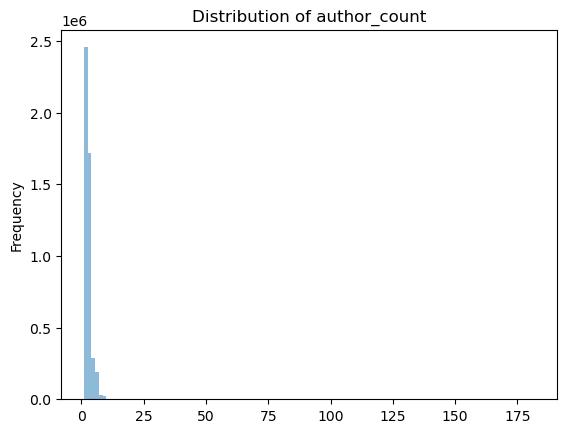

<Figure size 640x480 with 0 Axes>

In [ ]:
eda(paper_author_count, ["author_count"])

In [ ]:
paper_author_count.describe()

,author_count
count,4.718185e+06
mean,2.740893e+00
std,1.710161e+00
min,1.000000e+00
25%,2.000000e+00
50%,2.000000e+00
75%,3.000000e+00
max,1.820000e+02


In [ ]:
paper_author_count.head()

,paper_id,author_count
0,53a725db20f7420be8b5bfc6,1
1,53a725db20f7420be8b5bff3,2
2,53a725db20f7420be8b5bffb,1
3,53a725db20f7420be8b5c00f,2
4,53a727dc20f7420be8b9eed7,3


In [ ]:
low = .05
high = .95
quant_df = paper_author_count["author_count"].quantile([low, high])
print(quant_df)

0.05    1.0
0.95    6.0
Name: author_count, dtype: float64


In [ ]:
paper_author_count[paper_author_count["author_count"]==1].shape

(1083725, 2)

In [ ]:
paper_author_count[paper_author_count["author_count"]>=6].shape

(257786, 2)

In [ ]:
paper_author_count[paper_author_count["author_count"]==2].shape

(1371359, 2)

In [ ]:
paper_author_count[paper_author_count["author_count"]==3].shape

(1084713, 2)

In [ ]:
paper_author_count[paper_author_count["author_count"]>3].shape

(1178388, 2)

In [ ]:
paper_author_count_over1 = paper_author_count[paper_author_count["author_count"] > 1]
print(paper_author_count_over1.shape)

(3634460, 2)


In [ ]:
paper_author_count.shape

(4718185, 2)

In [ ]:
(1083725 / paper_author_count.shape[0]) *100

22.969107824301084

In [ ]:
3634460 + 1083725

4718185

In [ ]:
# get a list of paper id that has over 1 author id
list_distinct_paperid_that_has_authorid_over1 = paper_author_count_over1["paper_id"].unique()
print(paper_author_count_over1["paper_id"].nunique())
print(len(list_distinct_paperid_that_has_authorid_over1))

3634460
3634460


In [ ]:
# select useful columns, here do not select venue and fos, due to they are not cleaned.
paper = df[['id'
            , 'year'
            , 'lang'
            , 'title'
            , 'abstract'
            , 'keywords'
            ]]

In [ ]:
del df

In [ ]:
# create a new column which is the count of charactor of abstract
paper['abstract_length'] = paper['abstract'].str.len()

,id,year,lang,title,abstract,keywords,abstract_length
0,53e99784b7602d9701f3ffdd,2006.0,en,Flow.,NaN,[],NaN
1,53e99785b7602d9701f41492,1998.0,en,Dancing,NaN,[],NaN
2,53e99785b7602d9701f414a7,1972.0,en,Documentation,NaN,[],NaN
3,53e99785b7602d9701f414a8,1993.0,en,Datennetze,NaN,[],NaN
4,53e99785b7602d9701f414cb,2004.0,en,Drift,NaN,[],NaN


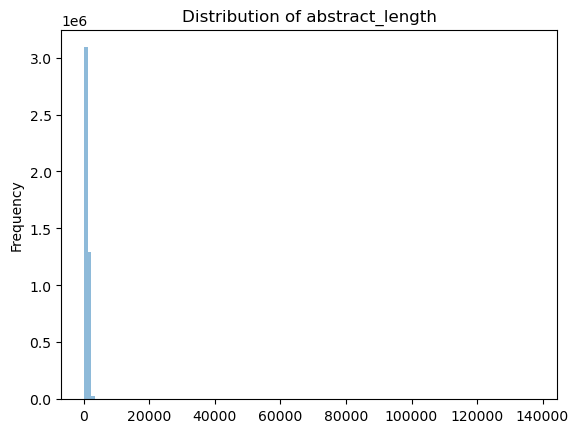

<Figure size 640x480 with 0 Axes>

In [ ]:
eda(paper, ["abstract_length"])

In [ ]:

# filter to keep paper whose author has authorid
paper_over1_author = paper[(paper["id"].isin(list_distinct_paperid_that_has_authorid_over1))
              ]
print(paper_over1_author.shape)

(3634460, 7)


## Filter 2: abstract length

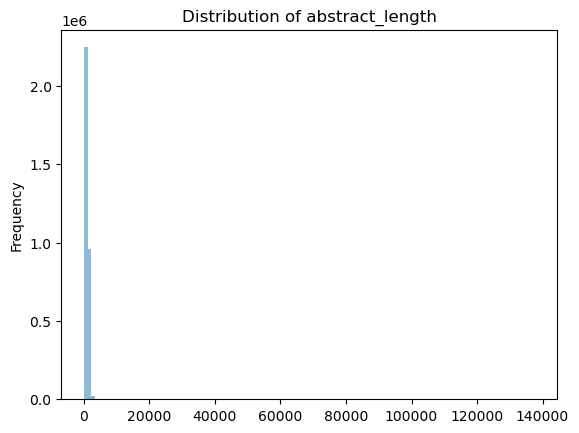

<Figure size 640x480 with 0 Axes>

In [ ]:
eda(paper_over1_author, ["abstract_length"])

In [ ]:
paper_over1_author[paper_over1_author["abstract"].isnull()].count()

id                 408572
year               408572
lang               365853
title              408572
abstract                0
keywords           408572
abstract_length         0
dtype: int64

In [ ]:
paper_over1_author[paper_over1_author["abstract_length"].isnull()].count()

id                 408572
year               408572
lang               365853
title              408572
abstract                0
keywords           408572
abstract_length         0
dtype: int64

In [ ]:
low = .05
high = .95
quant_df = paper_over1_author["abstract_length"].quantile([low, high])
print(quant_df)

0.05     391.0
0.95    1708.0
Name: abstract_length, dtype: float64


In [ ]:
paper_over1_author[paper_over1_author["abstract_length"]<391].shape

(161084, 7)

In [ ]:
paper_over1_author[paper_over1_author["abstract_length"]>1708].shape

(161160, 7)

In [ ]:
(paper_over1_author[paper_over1_author["abstract_length"]<=391].shape[0] + paper_over1_author[paper_over1_author["abstract_length"]>=1708].shape[0]) /paper_over1_author.shape[0]

0.08915079544141358

In [ ]:
paper_over1_author["abstract_length"].describe()

count    3.225888e+06
mean     9.751989e+02
std      5.011684e+02
min      1.000000e+00
25%      6.760000e+02
50%      9.400000e+02
75%      1.223000e+03
max      1.376490e+05
Name: abstract_length, dtype: float64

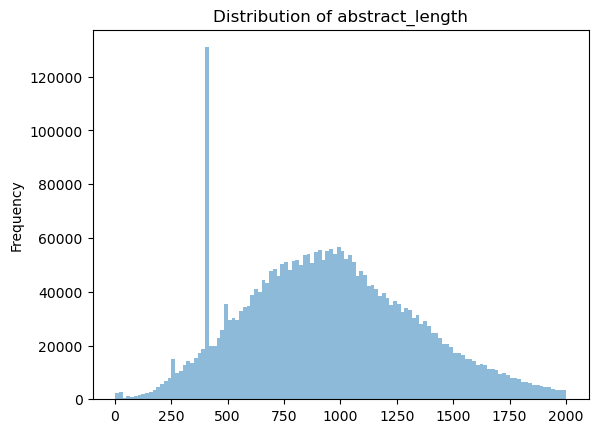

<Figure size 640x480 with 0 Axes>

In [ ]:
eda(paper_over1_author[paper_over1_author["abstract_length"]<= 2000], ["abstract_length"])

In [ ]:
paper_over1_author[paper_over1_author["abstract_length"] < 100].shape

(8868, 7)

In [ ]:
paper_over1_author[paper_over1_author["abstract_length"] < 200].shape

(24550, 7)

In [ ]:
paper_over1_author[paper_over1_author["abstract_length"] < 300].shape

(80023, 7)

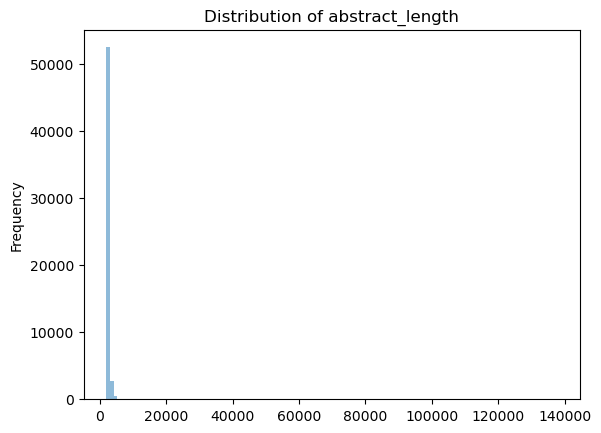

<Figure size 640x480 with 0 Axes>

In [ ]:
eda(paper_over1_author[paper_over1_author["abstract_length"]> 2000], ["abstract_length"])

In [ ]:
paper_over1_author[paper_over1_author["abstract_length"]> 2000].shape

(56008, 7)

In [ ]:
paper_over1_author[paper_over1_author["abstract_length"]> 5000].shape

(487, 7)

In [ ]:
paper_over1_author[paper_over1_author["abstract_length"]> 10000].shape

(171, 7)

In [ ]:
# filter2

paper_over1_author2 = paper_over1_author[
                      (paper_over1_author['abstract_length'] > 100) & (paper_over1_author['abstract_length'] <= 5000)
              ]
print(paper_over1_author.shape)
print(paper_over1_author2.shape)
print(paper_over1_author.shape[0] - paper_over1_author2.shape[0])

(3634460, 7)
(3216456, 7)
418004


In [ ]:
paper_over1_author2[paper_over1_author2["abstract"].isnull()].count()

id                 0
year               0
lang               0
title              0
abstract           0
keywords           0
abstract_length    0
dtype: int64

In [ ]:
paper_over1_author2[paper_over1_author2["abstract_length"].isnull()].count()

id                 0
year               0
lang               0
title              0
abstract           0
keywords           0
abstract_length    0
dtype: int64

In [ ]:
# read in paper to list of venue
paper_to_list_of_venue = pd.read_csv("./output/paper_to_list_of_venue.csv")
print(paper_to_list_of_venue.shape)
print(paper_to_list_of_venue["paper_id"].nunique())
display(paper_to_list_of_venue.head())

(5259858, 2)
5259858


,paper_id,list_of_venue
0,53a725db20f7420be8b5bfc6,['GI-Jahrestagung']
1,53a725db20f7420be8b5bff3,['PRINCIPLES AND PRACTICE OF CONSTRAINT PROGRA...
2,53a725db20f7420be8b5bffb,['IEEE Transactions on Smart Grid']
3,53a725db20f7420be8b5c00f,['LECTURE NOTES IN COMPUTER SCIENCE']
4,53a727dc20f7420be8b9eed7,['SIGCSE']


In [ ]:
# read in paper to list of filed of study
paper_to_list_of_fos = pd.read_csv("./output/paper_to_list_of_field_of_study.csv")
print(paper_to_list_of_fos.shape)
print(paper_to_list_of_fos["paper_id"].nunique())
display(paper_to_list_of_fos.head())



(3586177, 2)
3586177


,paper_id,list_of_field_of_study
0,53a725db20f7420be8b5c00f,"['Mathematical optimization', 'Partially obser..."
1,53a727dc20f7420be8b9eed7,"['Morpheme', 'Hit ratio', 'Computer science', ..."
2,53a727e620f7420be8ba0b4f,"['Health care', 'Data mining', 'Patient safety..."
3,53a728ee20f7420be8bbdf65,"['Inductive logic programming', 'Computer scie..."
4,53a728ee20f7420be8bbe037,"['Inductive logic programming', 'Graph kernel'..."


In [ ]:
df_modelling = paper_over1_author2.merge(paper_to_list_of_venue, how = "left", left_on = "id", right_on= "paper_id").drop(columns=["paper_id"])
print(paper_over1_author2.shape)
print(paper_to_list_of_venue.shape)
print(df_modelling.shape)

(3216456, 7)
(5259858, 2)
(3216456, 8)


In [ ]:
df_modelling = df_modelling.merge(paper_to_list_of_fos, how = "left", left_on= "id", right_on = "paper_id").drop(columns=["paper_id"])
print(paper_to_list_of_fos.shape)
print(df_modelling.shape)


(3586177, 2)
(3216456, 9)


In [ ]:
df_modelling.head()

,id,year,lang,title,abstract,keywords,abstract_length,list_of_venue,list_of_field_of_study
0,53e99785b7602d9701f4283f,2013.0,en,Express,The story is a sequel of a famous Japanese sto...,"['famous Japanese story', 'best friend', 'Gala...",198.0,['ACM SIGGRAPH 2013 Computer Animation Festival'],NaN
1,53e99785b7602d9701f43f95,2004.0,en,Bookshelf,Reviewed: Succeeding with Open Source Quality ...,"['415', '460', ' P.K.', ' Volume 4: Anticipati...",152.0,"['Software, IEEE']",NaN
2,53e9978ab7602d9701f45877,2009.0,en,Cherries,"Through a custom-created particle system, this...","['different sensual situation', 'custom-create...",130.0,['ACM SIGGRAPH 2009 Computer Animation Fesitval'],NaN
3,53e9978ab7602d9701f459c6,1975.0,en,Concurrency,A relation of concurrency can be defined in ev...,[],622.0,['Proceedings of the Advanced Course on Genera...,NaN
4,53e9978ab7602d9701f47342,1993.0,en,Causation,As cause we often specify an event the occurre...,[],498.0,['Journal of Philosophical Logic'],NaN


In [ ]:
df_modelling[df_modelling["lang"].isnull()].shape

(285681, 9)

In [ ]:
df_modelling.groupby("lang").size()

lang
de          7
en    2930756
es          1
fr          5
it          1
zh          5
dtype: int64

In [ ]:
df_modelling.to_csv("./output/paper.csv", index = False)

# Create list of index for Generative AI

In [ ]:
paper = pd.read_csv("./output/paper.csv")
print(paper.shape)
print(paper.isna().sum())
display(paper.head())

In [ ]:
# get a list of index
long_list = paper.index.to_list()
print(f"We have {len(long_list)} paper all together")

# shuffle the index
random.shuffle(long_list)

# number of sublists to split into
num_sublists = 50
print(f"To split the paper index into {num_sublists} list, each list has around {len(long_list)/num_sublists} paper")

# split into sublists
# for each of the first num_sublists (eg for each of 0 to 49),
# each select every num_sublists-th element (eg every 50th element) from the longlist
sublists = [long_list[i::num_sublists] for i in range(num_sublists)]

# check if the total length of sublist == origigal length
total_length = sum(len(sublist) for sublist in sublists)

# Print the total length
print("Total length of all sublists:", total_length)
assert total_length == len(long_list)

We have 3216456 paper all together
To split the paper index into 50 list, each list has around 64329.12 paper
Total length of all sublists: 3216456


In [ ]:
# save the sublists
for i, sublist in enumerate(sublists):
    with open(f'data/index_list/sublist_{i}.json', 'w') as f:
        json.dump(sublist, f)